## 7. Nonlinear ensemble filtering Lorenz 63 with fixed order Hermite map

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

[6] Tang, T., & Zhou, T. (2014). On discrete least-squares projection in unbounded domain with random evaluations and its application to parametric uncertainty quantification. SIAM Journal on Scientific Computing, 36(5), A2272-A2295.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.2

0.2

Define the time span of interest

In [6]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

500

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [8]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [9]:
### Process and observation noise
σx = 1e-5
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

In [10]:
ϵx.Σ

3×3 Diagonal{Float64,Array{Float64,1}}:
 1.0e-10   ⋅        ⋅ 
  ⋅       1.0e-10   ⋅ 
  ⋅        ⋅       1.0e-10

In [11]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [12]:
# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Set initial condition of the true system

In [13]:
x0 = rand(model.π0);

In [14]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [15]:
# Ensemble size
Ne = 800 

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×800 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.372473  2.29251    0.189558  …  -0.942111  -0.151645  -1.80006
 -0.111664  0.476202   0.098325     -1.25643   -0.25503    1.22431
  0.270537  0.482608  -1.44916       0.884268   0.462049  -0.262713

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [16]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [17]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


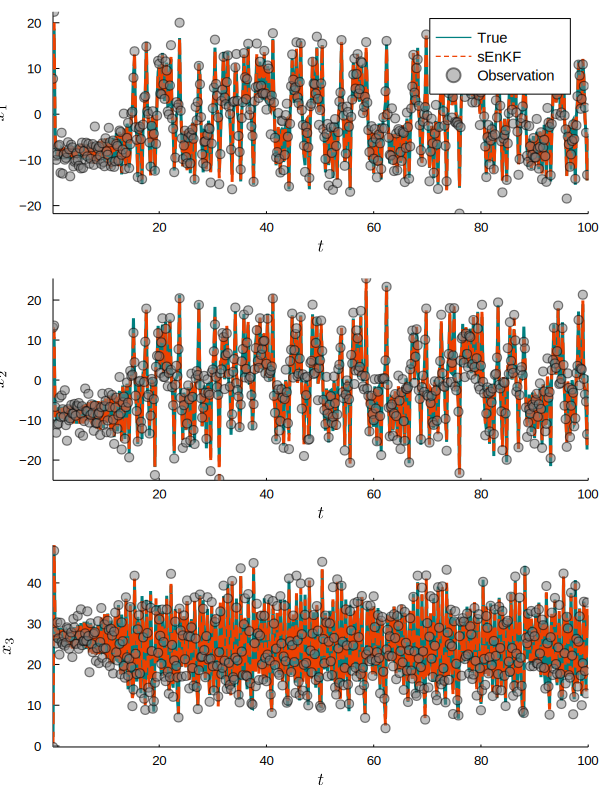

In [18]:
nb = 1
ne = Tf
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)),
         legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xenkf)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

We assess the performance of the different filters with the root-mean-squared error defined at the assimilation step $k$ as $RMSE_k = ||\overline{\boldsymbol{x}}_k - \boldsymbol{x}^\star_k||_2/\sqrt{N_x}$, where $\overline{\boldsymbol{x}}_k$ is the sample mean, and $\boldsymbol{x}^\star_k$ is the true state. Note: we only use the samples after spin-up phase of `Tspin` steps, see Spantini et al. [5].

In [19]:
tspin = 50.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

250

In [20]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.6886560008874787

In this notebook, we use an expansion of Hermite functions of fixed total  order to approximate the transport map. Again we face the bias-variance trade-off as a higher order provides a richer basis for estimation of the true map, but requires more samples to accurately estimate the coefficients of the expansion. As a guide, the number of samples required to estimate a map component of $N_{\psi}$ features should scaled as $O(N_{\psi}^2)$, see Thang & Zhou [6]. For a map of order $1$, we recover a linear approximation of the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$ Spantini et al. [5].

In [32]:
X0 = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

Initialize the structure of the map

In [33]:
S = totalordermap(X0, 2; b = "CstLinProHermite")

Hermite map of dimension 6:
Hermite map component of dimension 1 with Nψ = 2 active features
Hermite map component of dimension 2 with Nψ = 5 active features
Hermite map component of dimension 3 with Nψ = 9 active features
Hermite map component of dimension 4 with Nψ = 14 active features
Hermite map component of dimension 5 with Nψ = 20 active features
Hermite map component of dimension 6 with Nψ = 27 active features


For the 6-th map component, the set of features is:

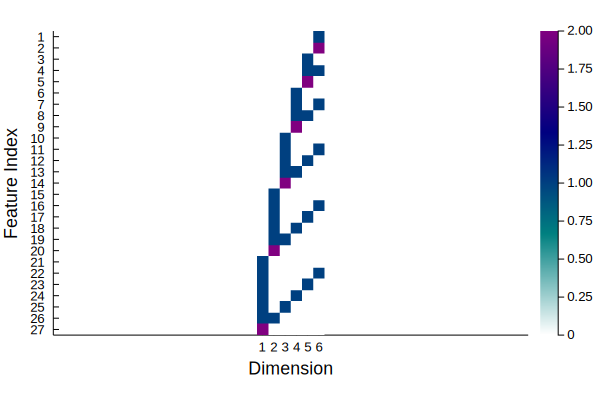

In [34]:
plot(S[6].I.f)

We define a new type of nonlinear filter `FixedHermiteSMF` that uses a fixed order expansion of multivariate Hermite functions to perform the inference. 

In [35]:
smf = FixedHermiteSMF(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, false)

Fixed Order Hermite Stochastic Map Filter with filtered = false


In [36]:
tsmf = 100.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs)

250

Generate the initial ensemble matrix `Xspin` from the run of the EnKF over the first `Tspin` steps. 

In [37]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))

6×800 Array{Float64,2}:
  0.0      0.0        0.0       0.0      …   0.0      0.0      0.0
  0.0      0.0        0.0       0.0          0.0      0.0      0.0
  0.0      0.0        0.0       0.0          0.0      0.0      0.0
  1.73033  0.627944   2.59438   3.47673      3.85506  1.92766  1.8077
  2.96585  1.2474     4.64156   6.26528      6.91327  3.5838   3.2663
 11.2806   9.09292   10.7757   10.9443   …  10.5163   9.31847  9.71036

In [38]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, Xspin, model.Ny, model.Nx, tspin);

Progress:  26%|██████████▌                              |  ETA: 0:10:55┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:15:52


We can compute the time average root-mean-squared-error with this nonlinear filter.

In [39]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

0.4584853009855915

Nice improvement with respect to the EnKF.

In [40]:
(rmse_enkf - rmse_smf)/rmse_enkf

0.3342317493861429

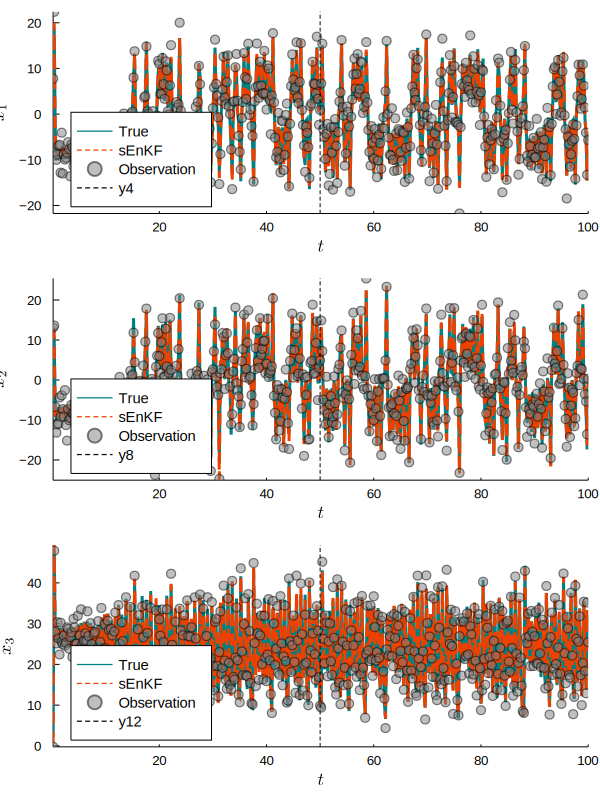

In [41]:
nb = 1
ne = Tspin+Tsmf
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash)
end

plt